# Flower Recognition

The aim of this project is to classify photos of some flowers. More specificly, from a Kaggle Dataset, we have five types of flowers: Daisies, Dandelions, Roses, Sunflowers and Tulips.

Also, this project can be seen also as a CNN tutorial. There is a step-by-step guide to perform a CNN classifier using Keras with a model designed my me, and another model using Transfer Learning.

Dataset:

https://www.kaggle.com/alxmamaev/flowers-recognition 

# Importing libs

In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns

from sklearn.model_selection import train_test_split

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Nadam, Adam
from keras.utils import to_categorical
from keras.layers import Dropout, Flatten, Input, Dense
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

 
import tensorflow as tf
import random
import cv2 as cv
import os 
import glob

Using TensorFlow backend.


# Reading and pre-processing the data

Setting the paths to the dataset

In [2]:
daisy_dir = glob.glob(os.path.join('daisy/', '*'))
dandelion_dir = glob.glob(os.path.join('dandelion/', '*'))
rose_dir = glob.glob(os.path.join('rose/', '*'))
sunflower_dir = glob.glob(os.path.join('sunflower/', '*'))
tulip_dir = glob.glob(os.path.join('tulip/', '*'))

On the Dandelion folder, there were some files that are not images. So I manually had to delete them.

Showing a example daisy image

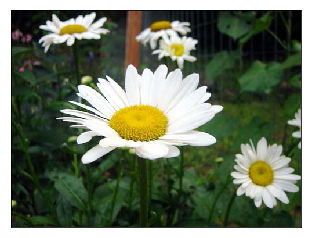

In [3]:
img_test = cv.imread(daisy_dir[50])
plt.imshow(img_test[:,:,::-1]) # BGR to RGB
plt.xticks([]), plt.yticks([]) # Hide the axis
plt.show()

Reading all the input data

In [4]:
X_path = daisy_dir + dandelion_dir + rose_dir + sunflower_dir + tulip_dir

X = []

for f in X_path:
    X.append(np.array(cv.resize(cv.imread(f), (224,224), interpolation = cv.INTER_AREA))) 
    
X = np.array(X)

X = X / 255

Creating the labels

In [5]:
l_daisy = np.zeros(len(daisy_dir))
l_dandelion = np.ones(len(dandelion_dir))
l_rose = 2*np.ones(len(rose_dir))
l_sunflower = 3*np.ones(len(sunflower_dir))
l_tulip = 4*np.ones(len(tulip_dir))

y = np.concatenate((l_daisy, l_dandelion, l_rose, l_sunflower, l_tulip))
y = to_categorical(y, 5)

### Spliting train and validation sets

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)
X = []

Data Augmentation to help with overfitting problems

In [7]:
# Data Augmentation
datagen = ImageDataGenerator(
        zoom_range = 0.1, # Aleatory zoom
        rotation_range= 15, 
        width_shift_range=0.1,  # horizontal shift
        height_shift_range=0.1,  # vertical shift
        horizontal_flip=True,  
        vertical_flip=True) 

datagen.fit(X_train)

Defining a CNN architecture

In [8]:
inp = Input((224,224,3))

conv1 = Conv2D(64, (5,5), padding='valid', activation= 'relu')(inp)
conv1 = MaxPooling2D(pool_size=(2,2))(conv1)
conv1 = BatchNormalization()(conv1)

conv2 = Conv2D(96, (4,4), padding='valid', activation= 'relu')(conv1)
conv2 = MaxPooling2D(pool_size=(2,2))(conv2)
conv2 = BatchNormalization()(conv2)

conv3 = Conv2D(128, (3,3), padding='valid', activation= 'relu')(conv2)
conv3 = MaxPooling2D(pool_size=(2,2))(conv3)
conv3 = BatchNormalization()(conv3)

conv4 = Conv2D(256, (3,3), padding='valid', activation= 'relu')(conv3)
conv4 = MaxPooling2D(pool_size=(2,2))(conv4)
conv4 = BatchNormalization()(conv4)

flat = Flatten()(conv4)

dense1 = Dense(512, activation= 'relu')(flat)
dense1 = Dropout(0.5)(dense1)

dense2 = Dense(64, activation= 'relu')(dense1)
dense2 = Dropout(0.1)(dense2)

out = Dense(5, activation = 'softmax')(dense2)

model = Model(inp, out)

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 64)      4864      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 110, 110, 64)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 110, 110, 64)      256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 107, 107, 96)      98400     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 53, 53, 96)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 53, 53, 96)        384       
__________

In [10]:
# Other things to the neural net
nadam = Nadam(lr = 0.0001)
adam = Adam(lr = 0.001)
filepath = 'my-CNN.{epoch:02d}-{loss:.2f}-{acc:.2f}-{val_loss:.2f}-{val_acc:.2f}.hdf5'
lr_red = keras.callbacks.ReduceLROnPlateau(monitor='acc', patience=3, verbose=1, factor=0.5, min_lr=0.000001)
chkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
model.compile(optimizer = nadam , loss = "categorical_crossentropy", metrics=["accuracy"])

In [11]:
history = model.fit(X_train, y_train, batch_size = 32, epochs = 75, initial_epoch = 0, 
                    validation_data = (X_val, y_val), callbacks=[lr_red, chkpoint])

Train on 3458 samples, validate on 865 samples
Epoch 1/25
3458/3458 [==============================] - 39s 11ms/step - loss: 6.4064 - acc: 0.3609 - val_loss: 5.4048 - val_acc: 0.2289
Epoch 2/25
3458/3458 [==============================] - 36s 10ms/step - loss: 3.4851 - acc: 0.3462 - val_loss: 3.4692 - val_acc: 0.3850
Epoch 3/25
3458/3458 [==============================] - 36s 10ms/step - loss: 2.5672 - acc: 0.3427 - val_loss: 2.5929 - val_acc: 0.4023
Epoch 4/25
3458/3458 [==============================] - 36s 10ms/step - loss: 1.6803 - acc: 0.3421 - val_loss: 1.4260 - val_acc: 0.3653

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/25
3458/3458 [==============================] - 36s 10ms/step - loss: 1.4439 - acc: 0.3462 - val_loss: 1.3251 - val_acc: 0.4139
Epoch 6/25
3458/3458 [==============================] - 36s 10ms/step - loss: 1.4449 - acc: 0.3650 - val_loss: 1.3216 - val_acc: 0.4173
Epoch 7/25
3458/3458 [==============================] - 

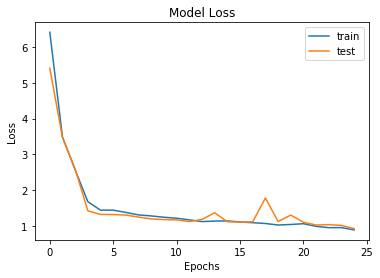

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

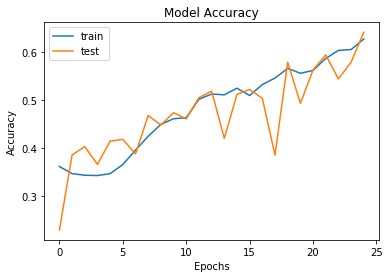

In [13]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()